# Improved LSTM baseline

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


We include the GloVe word vectors in our input files.

In [2]:
path = '../input/'
comp = 'jigsaw-toxic-comment-classification-challenge/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
# TEST_DATA_FILE=f'{path}test.csv'

Set some basic config parameters:

In [3]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a comment to use

Read in our data and replace missing values, train data is from wiki, 
test data can be selected from wiki or reddit data is from nba subreddit:

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
# test = pd.read_csv(TEST_DATA_FILE)
reddit_df=pd.read_csv('../input/reddit_nba_comment.csv')
reddit_df.columns=['id','comment_text']
test=reddit_df

list_sentences_train = train["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

Standard keras preprocessing, to turn each comment into a list of word indexes of equal length (with truncation or padding as needed).

In [5]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

Read the glove word vectors (space delimited strings) into a dictionary from word->vector.

In [6]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

Use these vectors to create our embedding matrix, with random initialization for words that aren't in GloVe. We'll use the same mean and stdev of embeddings the GloVe has when generating the random init.

In [7]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

/home/zhixing/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0.020940498, 0.6441043)

In [8]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

Simple bidirectional LSTM with two fully connected layers. We add some dropout to the LSTM since even 2 epochs is enough to overfit.

In [9]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Now we're ready to fit out model.

In [10]:
model.fit(X_t, y, batch_size=32, epochs=2, validation_split=0.1);

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 420s 3ms/step - loss: 0.0607 - acc: 0.9787 - val_loss: 0.0496 - val_acc: 0.9812
Epoch 2/2
143613/143613 [==============================] - 411s 3ms/step - loss: 0.0443 - acc: 0.9831 - val_loss: 0.0465 - val_acc: 0.9832


Save trained model

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [12]:
# # load json and create model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("model.h5")
# print("Loaded model from disk")

get predicted value, for kaggle competition need read sample_submission file

In [13]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
#sample_submission = pd.read_csv(f'{path}{comp}sample_submission.csv')
#sample_submission[list_classes] = y_test
# sample_submission.to_csv('submission.csv', index=False)

165714/165714 [==============================] - 48s 292us/step


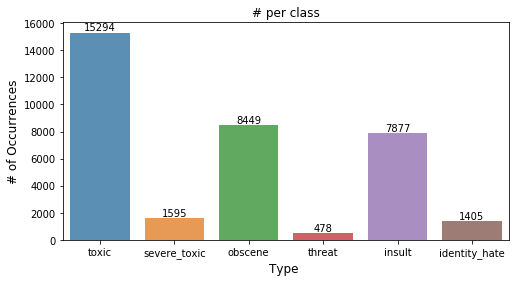

0.2199522469621673


In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns
from wordcloud import WordCloud ,STOPWORDS

x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print(x.sum()/len(train))

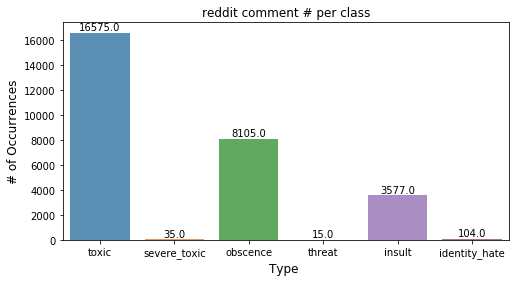

toxic ratio 0.1714459852516987


In [16]:
y_round=pd.DataFrame(y_test).round()
y_round.columns=['toxic','severe_toxic','obscence','threat','insult','identity_hate']
x=y_round.iloc[:,0:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("reddit comment # per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
print('toxic ratio',x.sum()/len(y_test))

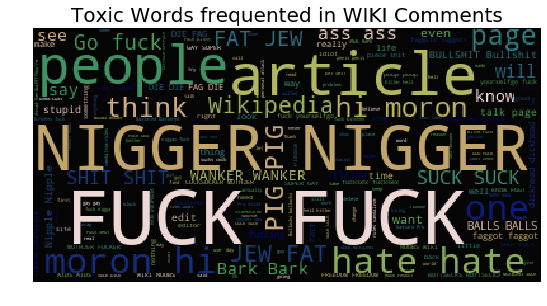

In [17]:
stopword=set(STOPWORDS)
subset=train[train.iloc[:,2:].sum(axis=1)!=0]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Toxic Words frequented in WIKI Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

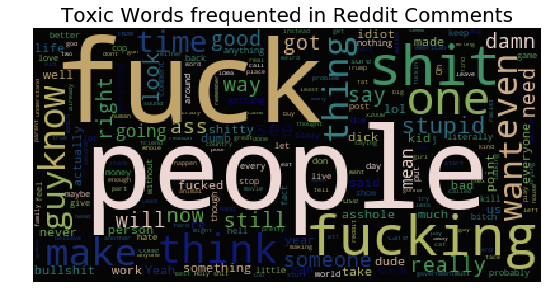

In [18]:
stopword=set(STOPWORDS)
subset=reddit_df[y_round.sum(axis=1)!=0]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Toxic Words frequented in Reddit Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)